# calculating fraction infectivities from excel output plate reader files
This notebook uses `excel_to_fractinfect_TM_InputFolder.py` to calculate fraction infectivities based on plate reader excel files in the subfolder `raw_plate_reader`. For the most part experiments are seperated by date, see `ExperimentDates.txt` for more details and for information on which fraction infectivities were instead calculated 'manually'. 

# outliers removed and normalized
**Because the outlier removal process did not change the data very much, we decided to scrap it. All outlier removal steps have been commented out, and the  follwoing sentence about outlier removal should be ignored.**

This version of the script removes any data points whose fraction infectivity lies over 1.5 to remove the most extreme outliers from the data set and hopefully reduce the noise on the curves (inidicated by or in file name). 
This version of the script also normalizes the IC50s of each sample to the IC50 of its batch control (inidciated by normalized in file name). 

`excel_to_fractinfect_TM_InputFolder.py` is a script that takes:
- a **folder** containing excel output files from the SkanIt plate reader software (make sure none of these are open on your device before running or you will get an error about the excel file type being unknown)
    - raw_plate_reader/your_file_name
- a **plate layout** from the PlateLayout folder located in the 'route' folder which defines sample positions in the plate
    - defaults to the LayoutTM.csv layout
- a **plate map**, which is a .csv which links the plate name to sample names and viruses tested, starting concentration, dilution factor **plate layout** file etc.
    - maps/your_file_name
- there are **two versions** of this script:
    - 'excel_to_fractinfect_TM_InputFolder.py': converts RLU to FI using the average pos_ctrl data for each plate
    - 'excel_to_fractinfect_TM_InputFolder_perrow.py': converts RLU to FI using each row's associated pos_ctrl value
    - specify the version after %run

The script outputs a processed file in the formt accepted by the neutcurve package. You should provide a descriptive name for this file. 
-   frac_infect/your_file_name

The **plate map** has columns:
- **Date_Read**: this is for record keeping and does not effect analysis 
- **Plate**: the name of the plate, exactly how it appears in the excel plate reader output file (2 cells below the `Wavelength: 0 nm` cell). If this is off by a space or character you will get an error when reading the plate.
- **Sample**: the sera sample name
- **SampleNum**: the sample position number designated by the plate layout file
- **Virus**: the virus added to the sample
- **PlateLayout**: the name of the file of your plate map that is located in the PlateLayout folder 
- **StartDil**: the starting dilution of sera on the plate 
- **DilFactor**: the dilution factor of the sera, pretty straightfoward.
- **Orientation**: `V` for vertical/tall (H-A at top) or `H` for horizontal/wide (1-12 at top)
- **background**: `keep` to keep background `cells only` values (designated in plate layout), `remove` to remove the average negative control RLU value from samples
Each row of *plate map* must have all of these column values. And each row refers to a sample on the plate. Look at layouts and example plate maps to get a better idea of how this works.
- **experiment_rep** any value, attached to output fraction infectivity file (used in our case to keep track of experiment type and replicate for each sample/virus+serum combo)

In [9]:
import pandas as pd
import numpy as np
import neutcurve

from math import floor, log10
from plotnine import *

In [10]:
from pathlib import Path
import os

from pathlib import Path

os.chdir("/fh/fast/bloom_j/computational_notebooks/gjuviler")
os.getcwd()

'/fh/fast/bloom_j/computational_notebooks/gjuviler'

## store all changeable variables:

In [33]:
bc_day = "08"     #select the day of the batch control (individual 2) that you want to be used in the final figure (08, 15, 16, 23, 29)

original_dataset = "moat_neuts/frac_infect/2026.01.08.15.16.23.29_all_batches_rabvg_perrow.csv"    #this is the dataset that is input in to the outlier removal script

serum_normal = '02-d28'     #this is the batch control serum ic50 value that is used to normalize the rest of the ic50s. In this case, it can be 02-28 or 02-56

input_template = "rabies_imprinting/01-data/slope_plot_input_template.csv"     #path to and name of the slope plot input template, with blank id50 columns. This can usually be left the same, but edit for different sera, etc.
    #the input template is especially important, as it must match exactly the order and labels for the sera in the id50 list. Otherwise, the plots will be inaccurate. 
    #any time you edit which sera you want plotted, you must edit the template to match
slope_plot_input = "rabies_imprinting/01-data/26.02.19_timepoint_plot_normalized.csv"     #provide a path and name for the slope plot input format with the id50s filled in 

plots_name = "rabies_imprinting/03-results/26.02.19_timepoint_plot_normalized.html"     #provide a path and name for the saved altair plots in html format

svg_name = "rabies_imprinting/03-results/26.02.19_timepoint_plot_normalized.svg"      #provide a path and name for the saved altair plots in svg format


## Convert

In [34]:
#run script
%run moat_neuts/excel_to_fractinfect_TM_InputFolder_perrow.py moat_neuts/raw_plate_reader/26.02.04_all_batches/ moat_neuts/frac_infect/2026.01.08.15.16.23.29_all_batches_rabvg_perrow.csv moat_neuts/maps/2026.08.15.16.23.29_all_batches_rabvg_map.csv moat_neuts/PlateLayouts

Processing file: moat_neuts/raw_plate_reader/26.02.04_all_batches/260108_neuts.xlsx
Processing plate: Plate 1
Processing plate: Plate 2
Processing plate: Plate 3
Processing plate: Plate 4
Processing plate: Plate 5
Processing file: moat_neuts/raw_plate_reader/26.02.04_all_batches/260115_neuts.xlsx
Processing plate: Plate 1_15
Processing plate: Plate 2_15
Processing plate: Plate 3_15
Processing plate: Plate 4_15
Processing plate: Plate 5_15
Processing plate: Plate 6_15
Processing file: moat_neuts/raw_plate_reader/26.02.04_all_batches/260116_neuts.xlsx
Processing plate: Plate 1_16
Processing plate: Plate 2_16
Processing plate: Plate 3_16
Processing plate: Plate 4_16
Processing plate: Plate 5_16
Processing plate: Plate 6_16
Processing plate: Plate 7_16
Processing plate: Plate 8_16
Processing file: moat_neuts/raw_plate_reader/26.02.04_all_batches/260123_neuts.xlsx
Processing plate: Plate 1_23
Processing plate: Plate 2_23
Processing plate: Plate 3_23
Processing plate: Plate 4_23
Processing p

## plot original dataset, generate ic50 table


In [35]:
datafile = original_dataset
data = pd.read_csv(datafile)
data.head()



,serum,virus,replicate,concentration,well_id,plate_name,experiment_rep,fraction infectivity,input_folder
0,01-d28,Batch 1 (26.01.08),1,0.20000,F2,Plate 1,NaN,0.000014,26.02.04_all_batches
1,01-d28,Batch 1 (26.01.08),1,0.04000,F3,Plate 1,NaN,0.000937,26.02.04_all_batches
2,01-d28,Batch 1 (26.01.08),1,0.00800,F4,Plate 1,NaN,0.036150,26.02.04_all_batches
3,01-d28,Batch 1 (26.01.08),1,0.00160,F5,Plate 1,NaN,0.091200,26.02.04_all_batches
4,01-d28,Batch 1 (26.01.08),1,0.00032,F6,Plate 1,NaN,0.165200,26.02.04_all_batches


In [36]:
data.tail()

,serum,virus,replicate,concentration,well_id,plate_name,experiment_rep,fraction infectivity,input_folder
1885,32-d365,Batch 5 (26.01.29),2,3.200000e-04,C6,Plate 8_29,NaN,0.6826,26.02.04_all_batches
1886,32-d365,Batch 5 (26.01.29),2,6.400000e-05,C7,Plate 8_29,NaN,0.8341,26.02.04_all_batches
1887,32-d365,Batch 5 (26.01.29),2,1.280000e-05,C8,Plate 8_29,NaN,0.8483,26.02.04_all_batches
1888,32-d365,Batch 5 (26.01.29),2,2.560000e-06,C9,Plate 8_29,NaN,1.0260,26.02.04_all_batches
1889,32-d365,Batch 5 (26.01.29),2,5.120000e-07,C10,Plate 8_29,NaN,1.0410,26.02.04_all_batches


/home/gjuviler/miniforge3/envs/juviler_jup/lib/python3.14/site-packages/neutcurve/hillcurve.py:1179: RuntimeWarning: invalid value encountered in power


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,01-d28,Batch 1 (26.01.08),average,2,0.000033,interpolated,3.28e-05,0.000033,0.000033,interpolated,0.883480,1.0,0.0,0.797521,0.228742
1,01-d56,Batch 1 (26.01.08),average,2,0.000073,interpolated,7.34e-05,0.000073,0.000073,interpolated,0.572218,1.0,0.0,0.995060,0.025246
2,01-d365,Batch 1 (26.01.08),average,2,0.000221,interpolated,0.000221,0.000221,0.000221,interpolated,0.759115,1.0,0.0,0.909374,0.135908
3,02-d28 (08),Batch 1 (26.01.08),average,2,0.000012,interpolated,1.23e-05,0.000012,0.000012,interpolated,0.679813,1.0,0.0,0.996137,0.020562
4,02-d56 (08),Batch 1 (26.01.08),average,2,0.000059,interpolated,5.92e-05,0.000059,0.000059,interpolated,0.619951,1.0,0.0,0.970955,0.060276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,31-d56,Batch 5 (26.01.29),average,2,0.000756,interpolated,0.000756,0.000756,0.000756,interpolated,0.852659,1.0,0.0,0.994845,0.029507
101,31-d365,Batch 5 (26.01.29),average,2,0.001637,interpolated,0.00164,0.001637,0.001637,interpolated,0.956606,1.0,0.0,0.906899,0.141845
102,32-d28,Batch 5 (26.01.29),average,2,0.000084,interpolated,8.4e-05,0.000084,0.000084,interpolated,0.763513,1.0,0.0,0.994702,0.029234
103,32-d56,Batch 5 (26.01.29),average,2,0.000420,interpolated,0.00042,0.000420,0.000420,interpolated,0.893647,1.0,0.0,0.997138,0.022641


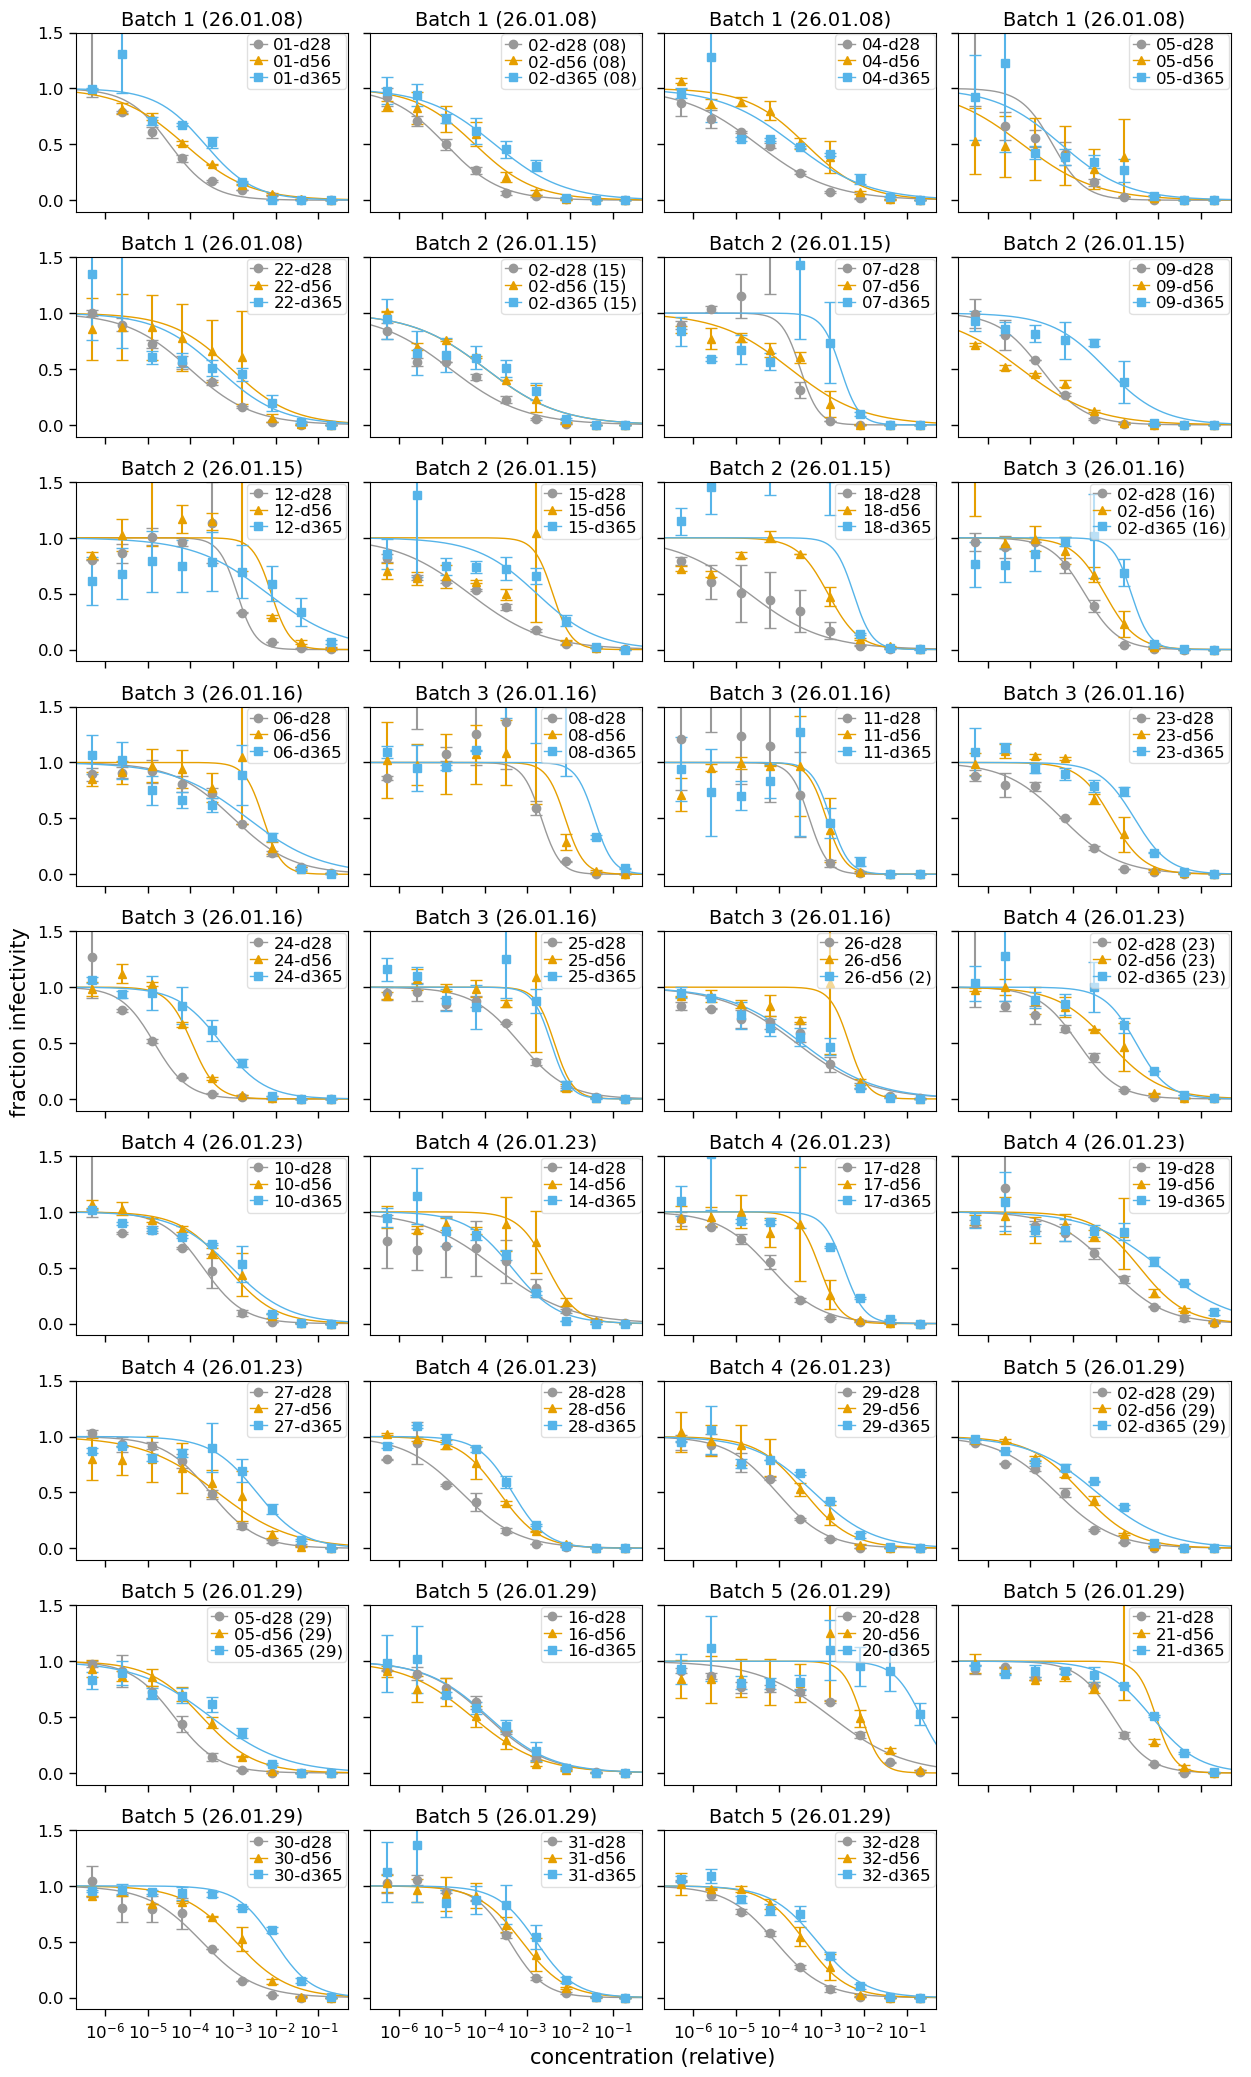

In [37]:
fits = neutcurve.CurveFits(data, fixtop=(1), fixslope=(0.5,2))
fig, axes = fits.plotViruses(xlabel="concentration (relative)", fix_lims = {"ymax": 1.5}, max_sera_per_subplot=3)
for ax in axes.flatten():
    leg = ax.get_legend()
    if leg is not None:
        leg.set_bbox_to_anchor((1, 1))     # move legend to top right of axes
        leg._loc = 1                       # 1 = upper right
        # Or: leg.set_loc("upper right")   # if your MPL version supports it


ic50_table = fits.fitParams()   #ic50 table for non outlier removed data
fits.fitParams()

## normalize each ic50 to its corresponding batch control d28 value
The ic50s are normalized and converted to id50 (inhibitory dilution 50, inverse of ic50) in a single step. This is done by dividing each 02-28 batch control by the ic50 values in its batch. This is the same as dividing ic50 by the batch control and then taking the inverse. 1/ (ic50/control) = control/ic50

In [38]:

id50s_normalized= []   #list of normalized id50 values
bc_ic50s = {}   #dict of batch control ic50 values in order

#create a dict of batch control ic50s for 02-28 sera. These will be the "normal" values for each batch 
for index, serum in enumerate(ic50_table.iloc[:, 0]):
    if serum.startswith(serum_normal):
        bc_ic50s[ic50_table.iloc[index, 1]] = ic50_table.iloc[index, 4] #store the batch control ic50s in a dict, where the key is the batch and the value is the ic50

#divide each ic50 by the normalizing value and store the resulting values in a list
for index, ic50 in enumerate(ic50_table.iloc[:, 4]):
    for batch in bc_ic50s:
        if batch == ic50_table.iloc[index, 1] and ((ic50_table.iloc[index, 0] == f'02-d28 ({bc_day})') | (ic50_table.iloc[index, 0] == f'02-d56 ({bc_day})') | (ic50_table.iloc[index, 0] == f'02-d365 ({bc_day})')):
            id50s_normalized.append(bc_ic50s[batch]/ic50)       #add the individual 2 run of your choice
        if batch == ic50_table.iloc[index, 1] and ((ic50_table.iloc[index, 0] == '05-d28 (29)') | (ic50_table.iloc[index, 0] == '05-d56 (29)') | (ic50_table.iloc[index, 0] == '05-d365 (29)')):
            id50s_normalized.append(bc_ic50s[batch]/ic50)       #keep the individual 5 rerun
        if batch == ic50_table.iloc[index, 1] and (ic50_table.iloc[index, 0].startswith('02') == False and ic50_table.iloc[index, 0].startswith('05') == False):
            id50s_normalized.append(bc_ic50s[batch]/ic50)     #store the all other normalized id50s (apart from batch controls and batch 1 individual 5) in a list called id50s_normalized

print(id50s_normalized)
print(bc_ic50s)

ic50_table


[np.float64(0.3739826530745488), np.float64(0.1670605278573033), np.float64(0.05555539736193), np.float64(1.0), np.float64(0.20692749521182513), np.float64(0.07061883762482582), np.float64(0.38540867583263716), np.float64(0.028581972833771098), np.float64(0.05252321163290638), np.float64(0.12612685799022824), np.float64(0.013411102478099122), np.float64(0.027549198080884577), np.float64(0.04922817811858137), np.float64(0.08409267811414775), np.float64(0.0055799778309795975), np.float64(0.8827794444716901), np.float64(2.597967039571283), np.float64(0.025949239358508524), np.float64(0.012571499294786416), np.float64(0.0020022853657926587), np.float64(0.00241399789448965), np.float64(0.35611420586331893), np.float64(0.0039816113073810515), np.float64(0.00940201989896239), np.float64(0.7792108737146595), np.float64(0.011068816662748228), np.float64(0.0027827018268395767), np.float64(0.18627712042736652), np.float64(0.03706716711775859), np.float64(0.08588384809084847), np.float64(0.0879289

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,01-d28,Batch 1 (26.01.08),average,2,0.000033,interpolated,3.28e-05,0.000033,0.000033,interpolated,0.883480,1.0,0.0,0.797521,0.228742
1,01-d56,Batch 1 (26.01.08),average,2,0.000073,interpolated,7.34e-05,0.000073,0.000073,interpolated,0.572218,1.0,0.0,0.995060,0.025246
2,01-d365,Batch 1 (26.01.08),average,2,0.000221,interpolated,0.000221,0.000221,0.000221,interpolated,0.759115,1.0,0.0,0.909374,0.135908
3,02-d28 (08),Batch 1 (26.01.08),average,2,0.000012,interpolated,1.23e-05,0.000012,0.000012,interpolated,0.679813,1.0,0.0,0.996137,0.020562
4,02-d56 (08),Batch 1 (26.01.08),average,2,0.000059,interpolated,5.92e-05,0.000059,0.000059,interpolated,0.619951,1.0,0.0,0.970955,0.060276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,31-d56,Batch 5 (26.01.29),average,2,0.000756,interpolated,0.000756,0.000756,0.000756,interpolated,0.852659,1.0,0.0,0.994845,0.029507
101,31-d365,Batch 5 (26.01.29),average,2,0.001637,interpolated,0.00164,0.001637,0.001637,interpolated,0.956606,1.0,0.0,0.906899,0.141845
102,32-d28,Batch 5 (26.01.29),average,2,0.000084,interpolated,8.4e-05,0.000084,0.000084,interpolated,0.763513,1.0,0.0,0.994702,0.029234
103,32-d56,Batch 5 (26.01.29),average,2,0.000420,interpolated,0.00042,0.000420,0.000420,interpolated,0.893647,1.0,0.0,0.997138,0.022641


## add the list of normalized id50 values to the slope plot input format

In [39]:

df_input = pd.read_csv(input_template)

for index, value in enumerate(df_input.iloc[:, 3]):
    df_input.iloc[index, 3] = id50s_normalized[index]
    df_input.iloc[index, 4] = id50s_normalized[index]

"""
for index, value in enumerate(df_input.iloc[:, 5]):    
    df_input.iloc[index, 5] = df_input.iloc[index, 5] + " (Normalized)"  #appends normalized to the cohort label 
"""
for index, value in enumerate(df_input.iloc[:, 1]):
    df_input.iloc[index, 1] = df_input.iloc[index, 1] + ' (Normalized)'    #appends normalized to timepoint

df_input.to_csv(slope_plot_input, index=False)
df_input

,serum,virus,ID,dilution,value,serum group,batch
0,1,d28 (Normalized),0.5,0.373983,0.373983,RIG d0,26.01.08
1,1,d56 (Normalized),0.5,0.167061,0.167061,RIG d0,26.01.08
2,1,d365 (Normalized),0.5,0.055555,0.055555,RIG d0,26.01.08
3,2,d28 (Normalized),0.5,1.000000,1.000000,No RIG,26.01.08
4,2,d56 (Normalized),0.5,0.206927,0.206927,No RIG,26.01.08
...,...,...,...,...,...,...,...
85,31,d56 (Normalized),0.5,0.054005,0.054005,RIG d28,26.01.29
86,31,d365 (Normalized),0.5,0.024934,0.024934,RIG d28,26.01.29
87,32,d28 (Normalized),0.5,0.486134,0.486134,No RIG,26.01.29
88,32,d56 (Normalized),0.5,0.097225,0.097225,No RIG,26.01.29


## Create the cleaned, normalized slope plots from the input file
The following code is adapted from slope_plots_26.01.30.ipynb, which was adapted from an extremely long Marimo notebook that Caelan sent me called 2025 - 11 - 21 RABVG neuts.py

In [40]:
import warnings
from matplotlib import pyplot as plt
import altair as alt
from pathlib import Path
from typing import List, Dict, Optional, Tuple

In [41]:
"""Configuration parameters."""
# Input/output settings
ID_table = pd.read_csv(slope_plot_input)
output_dir = "results/"

# Plotting parameters
plot_dpi = 300
curve_ymax = 1.2

# Slope plot options
generate_slope_plots = True  # Set to False to skip slope plot generation
use_id_for_slope = True  # If True, use ID50 instead of IC50 in slope plots
serum_groups_to_plot = None  # List of serum groups to include in slope plots, or None for all
# Example: serum_groups_to_plot = ['C-1', 'C-2', 'IgG']

# Note: This file now supports multiple viruses per plate!
# Format: virus=,,virus1,virus1,virus2,virus2,...

ID_table

,serum,virus,ID,dilution,value,serum group,batch
0,1,d28 (Normalized),0.5,0.373983,0.373983,RIG d0,26.01.08
1,1,d56 (Normalized),0.5,0.167061,0.167061,RIG d0,26.01.08
2,1,d365 (Normalized),0.5,0.055555,0.055555,RIG d0,26.01.08
3,2,d28 (Normalized),0.5,1.000000,1.000000,No RIG,26.01.08
4,2,d56 (Normalized),0.5,0.206927,0.206927,No RIG,26.01.08
...,...,...,...,...,...,...,...
85,31,d56 (Normalized),0.5,0.054005,0.054005,RIG d28,26.01.29
86,31,d365 (Normalized),0.5,0.024934,0.024934,RIG d28,26.01.29
87,32,d28 (Normalized),0.5,0.486134,0.486134,No RIG,26.01.29
88,32,d56 (Normalized),0.5,0.097225,0.097225,No RIG,26.01.29


In [42]:
"""Prepare data for slope plots."""

                      
if not generate_slope_plots:
    print("Slope plot generation disabled (generate_slope_plots = False)")
    slope_data = None
    virus_order = []
    plot_label = 'IC50'
    y_label = 'IC50 (nM)'
else:
    # Determine which table and settings to use
    if use_id_for_slope and ID_table is not None:
        table_to_plot = ID_table
        value_col = 'dilution'
        plot_label = 'Normalized NT50 Plotted by Timepoint'    #overall plot title at the top 
        y_label = 'Normalized NT50 (Neutralization Titer)'
        print("Using ID50 values for slope plot")
    else:
        table_to_plot = IC_table
        value_col = 'concentration'
        plot_label = 'IC50'
        y_label = 'IC50 (nM)'
        print("Using IC50 values for slope plot")

    # Prepare slope data with optional serum group filtering
    """BlockingIOError
    slope_data = prepare_slope_data(
        table_to_plot,
        value_col=value_col,
        ic_or_id_value=0.50,
        serum_groups_filter=serum_groups_to_plot
    )
    """
"""
    if len(slope_data) > 0:
        virus_order = natsort.natsorted(slope_data['virus'].unique().tolist())
        print(f"Prepared slope data: {len(slope_data)} points across {len(virus_order)} viruses")
    else:
        virus_order = []
        print(f"Warning: No valid slope data (all {plot_label} values are 0 or missing)")
        """

Using ID50 values for slope plot


'\n    if len(slope_data) > 0:\n        virus_order = natsort.natsorted(slope_data[\'virus\'].unique().tolist())\n        print(f"Prepared slope data: {len(slope_data)} points across {len(virus_order)} viruses")\n    else:\n        virus_order = []\n        print(f"Warning: No valid slope data (all {plot_label} values are 0 or missing)")\n        '

In [43]:
import altair as alt

virus_order = ["d28", "d56", "d365"]

highlight = alt.selection_point(fields=['serum'], on='mouseover', nearest=True)

# Jitter transform (adds random horizontal spread)
jitter = alt.Chart(ID_table).transform_calculate(
    jitter="sqrt(-2*log(random()))*cos(2*PI*random())"
)

# Individual jittered points
# Tighter horizontal jitter
jitter = (
    alt.Chart(ID_table)
    .transform_calculate(
        jitter="(random() - 0.5) * 0.01"   # controls jitter width
    )
)

# Individual jittered points
individual_points = (
    alt.Chart(ID_table)
    .transform_calculate(
        jitter="random() - 0.5"
    )
.mark_circle(size=60)
    .encode(
        x=alt.X(
            'serum group:N',
            title=None,
            scale=alt.Scale(
                paddingInner=0.8,  # ← increase space between columns
                paddingOuter=0.3   # ← space at ends
            ),
            axis=alt.Axis(
            labelAngle=-45,       
                #labelAlign='center',
                labelBaseline ='top',
                labelPadding=6
                )
        ),
        xOffset=alt.XOffset('jitter:Q'),  # small default jitter
        y=alt.Y(
            'value:Q',
            scale=alt.Scale(type='log'),
            title=y_label,
            axis=alt.Axis(labelPadding=6)
        ),
        color=alt.Color(
            'batch:N', title='Batch', 
            legend=alt.Legend(
                titleFontSize=18,
                labelFontSize=16,
                symbolSize=150
            )
        ),
        detail='serum:N',
        tooltip=[
            'serum',
            'serum group:N',
            'virus',
            alt.Tooltip('value:Q', format='.3f', title=y_label)
        ]
    )
)


# Median horizontal bar
median_bar = (
    alt.Chart(ID_table)
    .transform_aggregate(
        median_value='median(value)',
        groupby=['virus', 'serum group']
    )
    .mark_tick(
        orient='horizontal',   # 👈 forces horizontal
        color='black',
        thickness=4,
        size=40                # controls width of the bar
    )
    .encode(
        x='serum group:N',
        y='median_value:Q'
    )
)


base_chart = alt.layer(
    individual_points,
    median_bar
).properties(width=200, height=300)

faceted_chart = (
    base_chart
    .facet(
        column=alt.Column(
            'virus:N',
            sort=virus_order,
            title='Timepoint'       #label of each chart's title
        )
    )
    .configure_axisX(
        ticks=True,
        labelFontSize=18,
        titleFontSize=18,
        domainWidth=2,
        tickWidth=2,
        domainColor='black'
    )
    .configure_axisY(
        ticks=False,
        labelFontSize=14,
        titleFontSize=18,
        domainWidth = 2,
        domainColor='black'
    )
    .configure_header(
        labelFontSize=18,
        titleFontSize=18
    )
    .configure_title(
        fontSize=22
    )
    .resolve_scale(y='shared')
    .properties(title=f'{plot_label}')
)

faceted_chart.save(plots_name)
faceted_chart.save(svg_name)
faceted_chart


alt.FacetChart(...)